In [1]:
# Imports

import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from typing import TypeVar, List, Tuple, Union, Dict
from collections import Counter
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

import warnings
warnings.filterwarnings("ignore")

In [2]:
T = TypeVar('T')
seed = 42


class ArbolBinario:
    def __init__(self, profundidad_maxima: int, profundidad_actual: int = 0):
        self.valor: T = None
        self.caracteristica: int = None
        self.umbral: float = None
        self.izquierda: 'ArbolBinario' = None
        self.derecha: 'ArbolBinario' = None
        self.profundidad_maxima = profundidad_maxima
        self.profundidad_actual = profundidad_actual

    def insertar(self, data: List[Tuple[np.ndarray, int]]) -> None:
        if len(data) == 0:
            return
        etiquetas = [etiqueta for _, etiqueta in data]
        self.valor = max(set(etiquetas), key=etiquetas.count)

        if self.profundidad_actual >= self.profundidad_maxima or len(set(etiquetas)) == 1:
            return

        n_features = len(data[0][0])
        self.caracteristica = random.randint(0, n_features - 1)
        valores_caracteristica = [x[self.caracteristica] for x, _ in data]
        self.umbral = np.median(valores_caracteristica)

        izquierda_data = [(x, y) for x, y in data if x[self.caracteristica] <= self.umbral]
        derecha_data = [(x, y) for x, y in data if x[self.caracteristica] > self.umbral]

        self.izquierda = ArbolBinario(self.profundidad_maxima, self.profundidad_actual + 1)
        self.derecha = ArbolBinario(self.profundidad_maxima, self.profundidad_actual + 1)

        self.izquierda.insertar(izquierda_data)
        self.derecha.insertar(derecha_data)

    def predecir(self, instance: np.ndarray) -> T:
        if self.izquierda is None or self.derecha is None:
            return self.valor
        if instance[self.caracteristica] <= self.umbral:
            return self.izquierda.predecir(instance)
        else:
            return self.derecha.predecir(instance)


class RandomForest:
    def __init__(self, n_trees: int, bootstrap_rate: float, nivel_peso: float, profundidad_maxima: int):
        self.n_trees = n_trees
        self.bootstrap_rate = bootstrap_rate
        self.nivel_peso = nivel_peso
        self.profundidad_maxima = profundidad_maxima
        self.trees: List[ArbolBinario] = []

    def bootstrap_sample(self, data: List[Tuple[np.ndarray, int]]) -> List[Tuple[np.ndarray, int]]:
        sample_size = int(len(data) * self.bootstrap_rate)
        etiquetas = [etiqueta for _, etiqueta in data]
        conteo_etiquetas = Counter(etiquetas)

        pesos = {etiqueta: (conteo_etiquetas[etiqueta] ** self.nivel_peso) for etiqueta in conteo_etiquetas}
        total_pesos = sum(pesos.values())
        probabilidades = [pesos[etiqueta] / total_pesos for _, etiqueta in data]

        return random.choices(data, weights=probabilidades, k=sample_size)

    def train(self, data: List[Tuple[np.ndarray, int]]) -> None:
        for _ in range(self.n_trees):
            sample = self.bootstrap_sample(data)
            tree = ArbolBinario(self.profundidad_maxima)
            tree.insertar(sample)
            self.trees.append(tree)

    def predict(self, instance: np.ndarray) -> T:
        predictions = [tree.predecir(instance) for tree in self.trees]
        return max(set(predictions), key=predictions.count)

In [3]:
# Función para probar operaciones entre pares de nodos
def aplicar_operaciones(X: np.ndarray) -> np.ndarray:
    operaciones = [
        lambda a, b: a + b,
        lambda a, b: a - b,
        lambda a, b: a * b,
        lambda a, b: a / (b + 1e-5),  # Para evitar división por cero
    ]
    n_features = X.shape[1]
    nuevas_caracteristicas = []

    # Aplicar todas las operaciones entre pares de características
    for i, j in itertools.combinations(range(n_features), 2):
        for op in operaciones:
            nueva_caracteristica = op(X[:, i], X[:, j])
            nuevas_caracteristicas.append(nueva_caracteristica)

    return np.column_stack(nuevas_caracteristicas)


In [17]:
def params_analysis(X: np.ndarray, y: np.ndarray, n_trees_arr: np.ndarray, br_arr: np.ndarray, weight_level_arr: np.ndarray, max_depth_arr: np.ndarray, debug: bool = False) -> Tuple[Dict[str, Union[float, Tuple[float, float]]], List[float]]:
    best_params: dict[str, Union[int, float]] = {
        'accuracy': 0,
        'best_index': 0,
        'n_trees': 0,
        'br': 0,
        'weight_level': 0,
        'max_depth': 0,
    }
    accuracies = []
    index = 0
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train_transformado = aplicar_operaciones(X_train)
    X_test_transformado = aplicar_operaciones(X_test)

    for n_trees in n_trees_arr:
        for br in br_arr:
            for weight_level in weight_level_arr:
                for max_depth in max_depth_arr:
                    rf = RandomForest(n_trees=n_trees, bootstrap_rate=br, nivel_peso=weight_level, profundidad_maxima=max_depth)
                    rf.train([(x, label) for x, label in zip(X_train_transformado, y_train)])

                    # Realizar predicciones en el conjunto de entrenamiento y prueba
                    test_predictions = [rf.predict(instance) for instance in X_test_transformado]

                    # Calcular precisión en conjunto de prueba
                    test_accuracy = accuracy_score(y_test, test_predictions)
                    accuracies.append(test_accuracy)

                    if debug:
                        print(f"Params: n_trees={n_trees}, br={br}, weight_level={weight_level}, max_depth={max_depth}, accuracy={test_accuracy}")

                    if test_accuracy > best_params['accuracy']:
                        best_params['accuracy'] = test_accuracy
                        best_params['best_index'] = index
                        best_params['n_trees'] = n_trees
                        best_params['br'] = br
                        best_params['weight_level'] = weight_level
                        best_params['max_depth'] = max_depth

                    index += 1

    return best_params, accuracies

In [16]:
def params_analysis_cat(X: np.ndarray, y: np.ndarray, n_trees_arr: np.ndarray, br_arr: np.ndarray, weight_level_arr: np.ndarray, max_depth_arr: np.ndarray, debug: bool = False) -> Tuple[Dict[str, Union[float, Tuple[float, float]]], List[float]]:
    best_params: dict[str, Union[int, float]] = {
        'accuracy': 0,
        'best_index': 0,
        'n_trees': 0,
        'br': 0,
        'weight_level': 0,
        'max_depth': 0,
    }
    accuracies = []
    index = 0
    # Identify categorical columns
    categorical_columns = X.select_dtypes(include=['object']).columns
    
    # Apply one-hot encoding to categorical columns
    encoder = OneHotEncoder(sparse_output=False)
    X_encoded = encoder.fit_transform(X[categorical_columns])
    
    # Drop original categorical columns and concatenate encoded columns
    X = X.drop(categorical_columns, axis=1)
    X = np.concatenate([X.to_numpy(), X_encoded], axis=1)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    X_train_transformado = aplicar_operaciones(X_train)
    X_test_transformado = aplicar_operaciones(X_test)

    for n_trees in n_trees_arr:
        for br in br_arr:
            for weight_level in weight_level_arr:
                for max_depth in max_depth_arr:
                    rf = RandomForest(n_trees=n_trees, bootstrap_rate=br, nivel_peso=weight_level, profundidad_maxima=max_depth)
                    rf.train([(x, label) for x, label in zip(X_train_transformado, y_train)])

                    # Realizar predicciones en el conjunto de entrenamiento y prueba
                    test_predictions = [rf.predict(instance) for instance in X_test_transformado]

                    # Calcular precisión en conjunto de prueba
                    test_accuracy = accuracy_score(y_test, test_predictions)
                    accuracies.append(test_accuracy)

                    if debug:
                        print(f"Params: n_trees={n_trees}, br={br}, weight_level={weight_level}, max_depth={max_depth}, accuracy={test_accuracy}")

                    if test_accuracy > best_params['accuracy']:
                        best_params['accuracy'] = test_accuracy
                        best_params['best_index'] = index
                        best_params['n_trees'] = n_trees
                        best_params['br'] = br
                        best_params['weight_level'] = weight_level
                        best_params['max_depth'] = max_depth
                    
                    index += 1

    return best_params, accuracies

In [15]:
br_arr = np.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 2.0, 3.0, 4.0, 5.0])
weight_level_arr = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
n_trees_arr = np.array([10, 50, 100, 250, 500])
max_depth_arr = np.array([5])

def get_best_params(
        X: np.ndarray,
        y: np.ndarray,
        n_trees_arr: np.ndarray = n_trees_arr,
        br_arr: np.ndarray = br_arr,
        weight_level_arr: np.ndarray = weight_level_arr,
        max_depth_arr: np.ndarray = max_depth_arr,
        contains_categorical: bool = False,
        debug: bool = False
    ) -> Tuple[Dict[str, Union[float, Tuple[float, float]]], List[float]]:
    if contains_categorical:
        return params_analysis_cat(X, y, n_trees_arr, br_arr, weight_level_arr, max_depth_arr, debug)
    else:
        return params_analysis(X, y, n_trees_arr, br_arr, weight_level_arr, max_depth_arr, debug)

# Abalon (id=1)

In [18]:
abalon = fetch_ucirepo(id=1)

X = abalon.data.features # datos
y = abalon.data.targets # clases

abalon.variables

,name,role,type,demographic,description,units,missing_values
0,Sex,Feature,Categorical,None,"M, F, and I (infant)",None,no
1,Length,Feature,Continuous,None,Longest shell measurement,mm,no
2,Diameter,Feature,Continuous,None,perpendicular to length,mm,no
3,Height,Feature,Continuous,None,with meat in shell,mm,no
4,Whole_weight,Feature,Continuous,None,whole abalone,grams,no
5,Shucked_weight,Feature,Continuous,None,weight of meat,grams,no
6,Viscera_weight,Feature,Continuous,None,gut weight (after bleeding),grams,no
7,Shell_weight,Feature,Continuous,None,after being dried,grams,no
8,Rings,Target,Integer,None,+1.5 gives the age in years,None,no


In [8]:
abalon.data.features

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


In [19]:
best_params, accuracies = get_best_params(X=X, y=y.to_numpy().flatten(), contains_categorical=True)

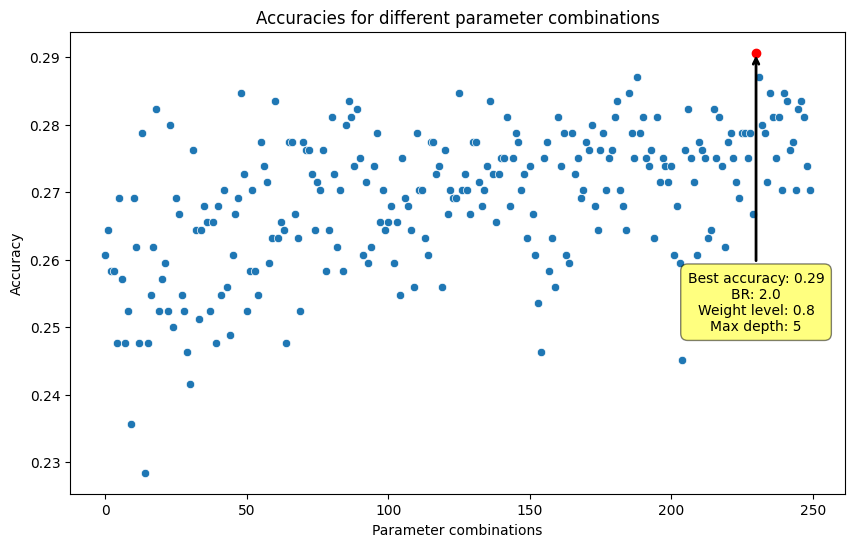

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(accuracies)), y=accuracies)
plt.scatter(best_params['best_index'], best_params['accuracy'], color='red', label='Best accuracy')
plt.annotate(
    f"Best accuracy: {best_params['accuracy']:.2f}\nBR: {best_params['br']}\nWeight level: {best_params['weight_level']}\nMax depth: {best_params['max_depth']}", 
    (best_params['best_index'], best_params['accuracy']), textcoords="offset points", xytext=(0, -200), ha='center', bbox=dict(
        boxstyle='round,pad=0.5', fc='yellow', alpha=0.5
    ),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=2)
)
plt.xlabel('Parameter combinations')
plt.ylabel('Accuracy')
plt.title('Accuracies for different parameter combinations for Abalon dataset')
plt.show()

In [ ]:
with open('results/abalon.npy', 'wb') as f:
    np.save(f, best_params)
    np.save(f, accuracies)

In [54]:
with open('results/abalon.npy', 'rb') as f:
    best_params = np.load(f, allow_pickle=True).item()
    accuracies = np.load(f, allow_pickle=True)

# Australian Credit Approval (Statlog)

In [59]:
statlog_australian_credit_approval = fetch_ucirepo(id=143)

X = statlog_australian_credit_approval.data.features 
y = statlog_australian_credit_approval.data.targets

statlog_australian_credit_approval.variables

,name,role,type,demographic,description,units,missing_values
0,A1,Feature,Categorical,None,None,None,no
1,A2,Feature,Continuous,None,None,None,no
2,A3,Feature,Continuous,None,None,None,no
3,A4,Feature,Categorical,None,None,None,no
4,A5,Feature,Categorical,None,None,None,no
5,A6,Feature,Categorical,None,None,None,no
6,A7,Feature,Continuous,None,None,None,no
7,A8,Feature,Categorical,None,None,None,no
8,A9,Feature,Categorical,None,None,None,no
9,A10,Feature,Continuous,None,None,None,no


In [56]:
statlog_australian_credit_approval.data.features

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213
1,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1
2,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1
3,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1
4,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1
686,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45
687,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1
688,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12


In [60]:
best_params, accuracies = get_best_params(X=X, y=y.to_numpy().flatten(), contains_categorical=True)

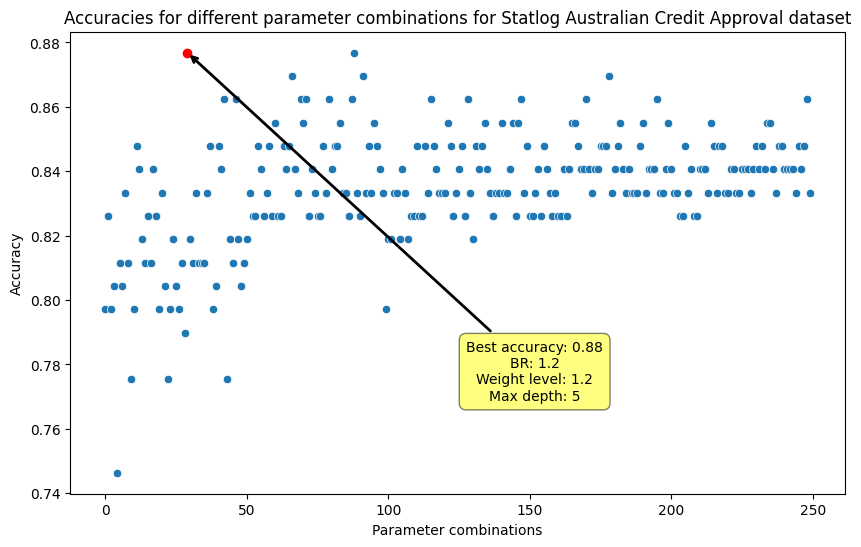

In [63]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(accuracies)), y=accuracies)
plt.scatter(best_params['best_index'], best_params['accuracy'], color='red', label='Best accuracy')
plt.annotate(
    f"Best accuracy: {best_params['accuracy']:.2f}\nBR: {best_params['br']}\nWeight level: {best_params['weight_level']}\nMax depth: {best_params['max_depth']}", 
    (best_params['best_index'], best_params['accuracy']), textcoords="offset points", xytext=(250, -250), ha='center', bbox=dict(
        boxstyle='round,pad=0.5', fc='yellow', alpha=0.5
    ),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=2)
)
plt.xlabel('Parameter combinations')
plt.ylabel('Accuracy')
plt.title('Accuracies for different parameter combinations for Statlog Australian Credit Approval dataset')
plt.show()

In [64]:
with open('results/statlog.npy', 'wb') as f:
    np.save(f, best_params)
    np.save(f, accuracies)

# Horse Colic

In [65]:
horse_colic = fetch_ucirepo(id=47)

X = horse_colic.data.features
y = horse_colic.data.targets

horse_colic.variables

,name,role,type,demographic,description,units,missing_values
0,surgery,Feature,Integer,None,None,None,yes
1,age,Feature,Integer,Age,None,None,no
2,hospital_number,Feature,Integer,None,None,None,no
3,rectal_temperature,Feature,Continuous,None,None,None,yes
4,pulse,Feature,Integer,None,None,None,yes
5,respiratory_rate,Feature,Integer,None,None,None,yes
6,temperature_of_extremities,Feature,Integer,None,None,None,yes
7,peripheral_pulse,Feature,Integer,None,None,None,yes
8,mucous_membranes,Feature,Integer,None,None,None,yes
9,capillary_refill_time,Feature,Integer,None,None,None,yes


In [66]:
horse_colic.data.features

,surgery,age,hospital_number,rectal_temperature,pulse,respiratory_rate,temperature_of_extremities,peripheral_pulse,mucous_membranes,capillary_refill_time,...,abdomen,packed_cell_volume,total_protein,abdominocentesis_appearance,abdominocentesis_total_protein,outcome,lesion_site,lesion_type,lesion_subtype,cp_data
0,2.0,1,530101,38.5,66.0,28.0,3.0,3.0,NaN,2.0,...,5.0,45.0,8.4,NaN,NaN,2.0,11300,0,0,2
1,1.0,1,534817,39.2,88.0,20.0,NaN,NaN,4.0,1.0,...,2.0,50.0,85.0,2.0,2.0,3.0,2208,0,0,2
2,2.0,1,530334,38.3,40.0,24.0,1.0,1.0,3.0,1.0,...,1.0,33.0,6.7,NaN,NaN,1.0,0,0,0,1
3,1.0,9,5290409,39.1,164.0,84.0,4.0,1.0,6.0,2.0,...,NaN,48.0,7.2,3.0,5.3,2.0,2208,0,0,1
4,2.0,1,530255,37.3,104.0,35.0,NaN,NaN,6.0,2.0,...,NaN,74.0,7.4,NaN,NaN,2.0,4300,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,2.0,1,529695,38.6,60.0,30.0,1.0,1.0,3.0,1.0,...,NaN,40.0,6.0,1.0,NaN,1.0,3205,0,0,2
364,2.0,1,528452,37.8,42.0,40.0,1.0,1.0,1.0,1.0,...,3.0,36.0,6.2,NaN,NaN,1.0,4124,0,0,2
365,1.0,1,534783,38.0,60.0,12.0,1.0,1.0,2.0,1.0,...,4.0,44.0,65.0,3.0,2.0,3.0,2209,0,0,2
366,2.0,1,528926,38.0,42.0,12.0,3.0,NaN,3.0,1.0,...,1.0,37.0,5.8,NaN,NaN,1.0,3111,0,0,2


In [67]:
# Initialize KNN Imputer
imputer = KNNImputer(n_neighbors= 5) #Fills missing values based on the values of the nearest neighbors.
# Fit & Transform the data 
numeric_df = X.select_dtypes(include='float64')
imputed_Hepatits = imputer.fit_transform(numeric_df)
# Create a DataFrame from the imputed Data
imputed_df = pd.DataFrame(imputed_Hepatits ,columns=numeric_df.columns) 
# Replace the original numeric columns with the imputed  data
X[numeric_df.columns] = imputed_df
# Check Null Values
X.isna().sum()

surgery                           0
age                               0
hospital_number                   0
rectal_temperature                0
pulse                             0
respiratory_rate                  0
temperature_of_extremities        0
peripheral_pulse                  0
mucous_membranes                  0
capillary_refill_time             0
pain                              0
peristalsis                       0
abdominal_distension              0
nasogastric_tube                  0
nasogastric_reflux                0
nasogastric_reflux_ph             0
rectal_examination_feces          0
abdomen                           0
packed_cell_volume                0
total_protein                     0
abdominocentesis_appearance       0
abdominocentesis_total_protein    0
outcome                           0
lesion_site                       0
lesion_type                       0
lesion_subtype                    0
cp_data                           0
dtype: int64

In [68]:
best_params, accuracies = get_best_params(X=X.to_numpy(), y=y.to_numpy().flatten())

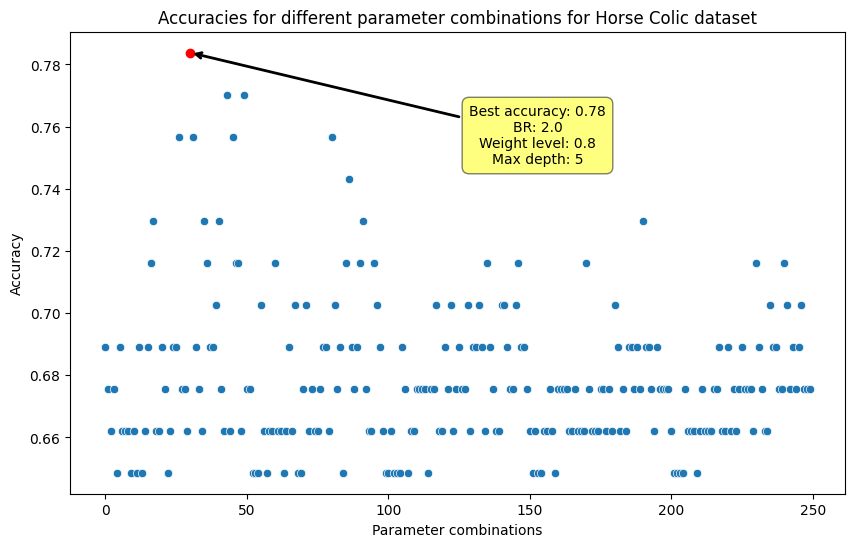

In [71]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(accuracies)), y=accuracies)
plt.scatter(best_params['best_index'], best_params['accuracy'], color='red', label='Best accuracy')
plt.annotate(
    f"Best accuracy: {best_params['accuracy']:.2f}\nBR: {best_params['br']}\nWeight level: {best_params['weight_level']}\nMax depth: {best_params['max_depth']}", 
    (best_params['best_index'], best_params['accuracy']), textcoords="offset points", xytext=(250, -80), ha='center', bbox=dict(
        boxstyle='round,pad=0.5', fc='yellow', alpha=0.5
    ),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=2)
)
plt.xlabel('Parameter combinations')
plt.ylabel('Accuracy')
plt.title('Accuracies for different parameter combinations for Horse Colic dataset')
plt.show()

In [72]:
with open('results/horse_colic.npy', 'wb') as f:
    np.save(f, best_params)
    np.save(f, accuracies)

# Hepatitis

In [73]:
hepatitis = fetch_ucirepo(id=46)

X = hepatitis.data.features # datos
y = hepatitis.data.targets # clases

hepatitis.variables

,name,role,type,demographic,description,units,missing_values
0,Class,Target,Categorical,None,None,None,no
1,Age,Feature,Integer,None,None,None,no
2,Sex,Feature,Categorical,None,None,None,no
3,Steroid,Feature,Categorical,None,None,None,yes
4,Antivirals,Feature,Categorical,None,None,None,no
5,Fatigue,Feature,Categorical,None,None,None,yes
6,Malaise,Feature,Categorical,None,None,None,yes
7,Anorexia,Feature,Categorical,None,None,None,yes
8,Liver Big,Feature,Categorical,None,None,None,yes
9,Liver Firm,Feature,Categorical,None,None,None,yes


In [74]:
hepatitis.data.features

,Age,Sex,Steroid,Antivirals,Fatigue,Malaise,Anorexia,Liver Big,Liver Firm,Spleen Palpable,Spiders,Ascites,Varices,Bilirubin,Alk Phosphate,Sgot,Albumin,Protime,Histology
0,30,2,1.0,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,85.0,18.0,4.0,NaN,1
1,50,1,1.0,2,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,0.9,135.0,42.0,3.5,NaN,1
2,78,1,2.0,2,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.7,96.0,32.0,4.0,NaN,1
3,31,1,NaN,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.7,46.0,52.0,4.0,80.0,1
4,34,1,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,NaN,200.0,4.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,46,1,2.0,2,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,7.6,NaN,242.0,3.3,50.0,2
151,44,1,2.0,2,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0.9,126.0,142.0,4.3,NaN,2
152,61,1,1.0,2,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,0.8,75.0,20.0,4.1,NaN,2
153,53,2,1.0,2,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.5,81.0,19.0,4.1,48.0,2


In [75]:
# Initialize KNN Imputer
imputer = KNNImputer(n_neighbors= 5) #Fills missing values based on the values of the nearest neighbors.
# Fit & Transform the data 
numeric_df = X.select_dtypes(include='float64')
imputed_Hepatits = imputer.fit_transform(numeric_df)
# Create a DataFrame from the imputed Data
imputed_df = pd.DataFrame(imputed_Hepatits ,columns=numeric_df.columns) 
# Replace the original numeric columns with the imputed  data
X[numeric_df.columns] = imputed_df
# Check Null Values
X.isna().sum()

Age                0
Sex                0
Steroid            0
Antivirals         0
Fatigue            0
Malaise            0
Anorexia           0
Liver Big          0
Liver Firm         0
Spleen Palpable    0
Spiders            0
Ascites            0
Varices            0
Bilirubin          0
Alk Phosphate      0
Sgot               0
Albumin            0
Protime            0
Histology          0
dtype: int64

In [76]:
best_params, accuracies = get_best_params(X=X, y=y.to_numpy().flatten(), contains_categorical=True)

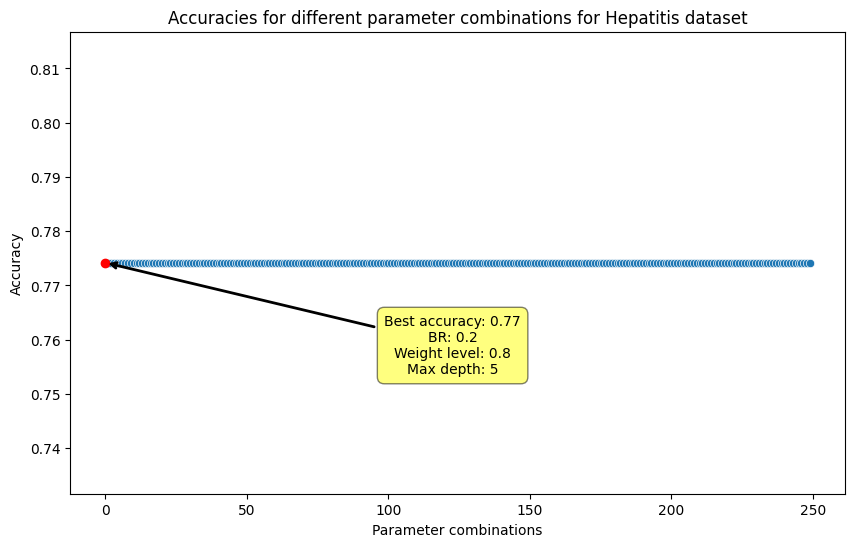

In [77]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(accuracies)), y=accuracies)
plt.scatter(best_params['best_index'], best_params['accuracy'], color='red', label='Best accuracy')
plt.annotate(
    f"Best accuracy: {best_params['accuracy']:.2f}\nBR: {best_params['br']}\nWeight level: {best_params['weight_level']}\nMax depth: {best_params['max_depth']}", 
    (best_params['best_index'], best_params['accuracy']), textcoords="offset points", xytext=(250, -80), ha='center', bbox=dict(
        boxstyle='round,pad=0.5', fc='yellow', alpha=0.5
    ),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=2)
)
plt.xlabel('Parameter combinations')
plt.ylabel('Accuracy')
plt.title('Accuracies for different parameter combinations for Hepatitis dataset')
plt.show()

In [78]:
with open('results/hepatitis.npy', 'wb') as f:
    np.save(f, best_params)
    np.save(f, accuracies)

# Adult

In [79]:
adult = fetch_ucirepo(id=2) 

X = adult.data.features # datos
y = adult.data.targets # clases

adult.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [80]:
adult.data.features

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


In [81]:
X.occupation.fillna('?', inplace=True)
X.workclass.fillna('?', inplace=True)
X['native-country'].fillna('?', inplace=True)
X.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

In [82]:
best_params, accuracies = get_best_params(X=X, y=y.to_numpy().flatten(), contains_categorical=True)

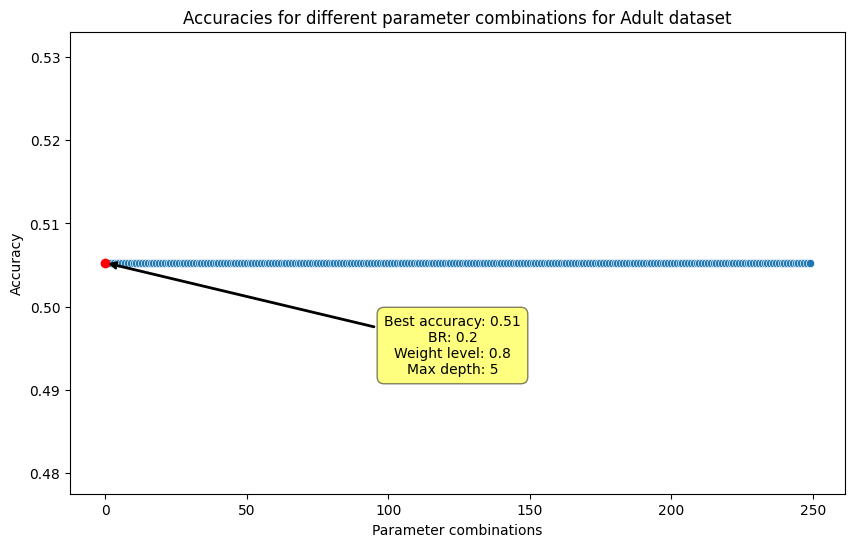

In [83]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(accuracies)), y=accuracies)
plt.scatter(best_params['best_index'], best_params['accuracy'], color='red', label='Best accuracy')
plt.annotate(
    f"Best accuracy: {best_params['accuracy']:.2f}\nBR: {best_params['br']}\nWeight level: {best_params['weight_level']}\nMax depth: {best_params['max_depth']}", 
    (best_params['best_index'], best_params['accuracy']), textcoords="offset points", xytext=(250, -80), ha='center', bbox=dict(
        boxstyle='round,pad=0.5', fc='yellow', alpha=0.5
    ),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=2)
)
plt.xlabel('Parameter combinations')
plt.ylabel('Accuracy')
plt.title('Accuracies for different parameter combinations for Adult dataset')
plt.show()

In [84]:
with open('results/adult.npy', 'wb') as f:
    np.save(f, best_params)
    np.save(f, accuracies)